In [50]:
!pip install datasets pandas torch openpyxl banglanltk bangla-stemmer gensim pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import time
from bangla_stemmer.stemmer import stemmer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

# **Train Dataset Loading**

In [52]:
# Read the xlxs file into a DataFrame

train_data  = pd.read_excel("/content/AUG_Revolt_24 - Sheet1.xlsx")
stopwords_df = pd.read_excel('/content/stopwords_bangla.xlsx')
# Display the DataFrame
train_data.head()

,date,Headline,Sentiment
0,2024-07-05,ঢাকা বিশ্ববিদ্যালয়: কোটাবিরোধী আন্দোলনের নেতাক...,outrage
1,2024-07-05,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,2024-07-05,কোটাবিরোধী আন্দোলন : আজও জিরো পয়েন্ট অবরোধ করে...,outrage
3,2024-07-06,"সর্বজনীন পেনশন: সরকার অনড়, আন্দোলন চালিয়ে যাবে...",outrage
4,2024-07-06,আজ শনিবার সকাল সাড়ে ১০টার দিকে মহাসড়কের শহর বা...,outrage


In [53]:
stopwords_df.head()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ


In [54]:
# drop date
train_data = train_data.drop('date', axis=1)

In [59]:
import re

def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\u2600-\u26FF"          # miscellaneous symbols
                               u"\u2700-\u27BF"          # dingbats
                               u"\u2000-\u206F"          # general punctuations
                               "]+", flags=re.UNICODE)
    english_pattern = re.compile('[a-zA-Z]+', flags=re.I)

    text = emoji_pattern.sub(r'', text)
    text = english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct += char

    return no_punct

def preprocessing(text):
    text = replace_strings(text)
    text = remove_punctuations(text)
    return text

In [60]:
# prompt: for each Headline column of posts_df, apply the preprocessing function to each row

train_data['Headline'] =train_data['Headline'].apply(lambda x: preprocessing(str(x)))
train_data.head()

,Headline,Sentiment
0,ঢাকা বিশ্ববিদ্যালয় কোটাবিরোধী আন্দোলনের নেতাকে...,outrage
1,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,কোটাবিরোধী আন্দোলন আজও জিরো পয়েন্ট অবরোধ করে ...,outrage
3,সর্বজনীন পেনশন সরকার অনড় আন্দোলন চালিয়ে যাবেন ...,outrage
4,আজ শনিবার সকাল সাড়ে টার দিকে মহাসড়কের শহর বাইপ...,outrage


In [61]:
# Remove Stopwords
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stopwords_df]

    out=' '.join(stm)

    return str(out)

In [62]:
train_data['Headline'] =train_data['Headline'].apply(lambda x: stopwordRemoval(str(x)))
train_data.head()

,Headline,Sentiment
0,ঢাকা বিশ্ববিদ্যালয় কোটাবিরোধী আন্দোলনের নেতাকে...,outrage
1,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,কোটাবিরোধী আন্দোলন আজও জিরো পয়েন্ট অবরোধ করে খ...,outrage
3,সর্বজনীন পেনশন সরকার অনড় আন্দোলন চালিয়ে যাবেন ...,outrage
4,আজ শনিবার সকাল সাড়ে টার দিকে মহাসড়কের শহর বাইপ...,outrage


In [63]:
# stemmer function
def stem_text(x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [64]:
train_data['Headline'] =train_data['Headline'].apply(lambda x: stem_text(str(x)))

Streaming output truncated to the last 5000 lines.
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rule

In [65]:
#make test_data and val data_from train_data
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42,stratify=train_data['Sentiment'])
# make test data from val data
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42,stratify=val_data['Sentiment'])

In [66]:
len(train_data)

1759

In [67]:
len(test_data)

378

In [68]:
len(val_data)

377

In [69]:
label_counts = train_data['Sentiment'].value_counts()
label_counts

,count
Sentiment,
despair,587
hope,586
outrage,586


# **Visualization of Label Distribution in Train Dataset**
  

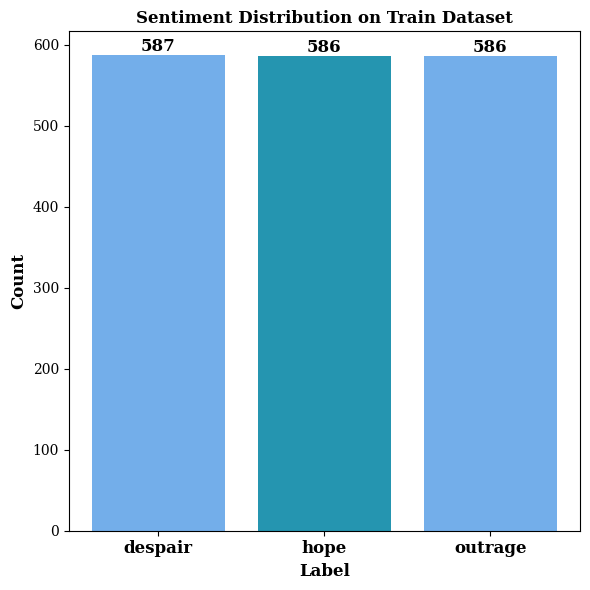

In [70]:
label_counts = train_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Train Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('Rev_train.pdf')  # Save as pdf format
plt.show()


# **Visualization of Label Distribution in Test Dataset**


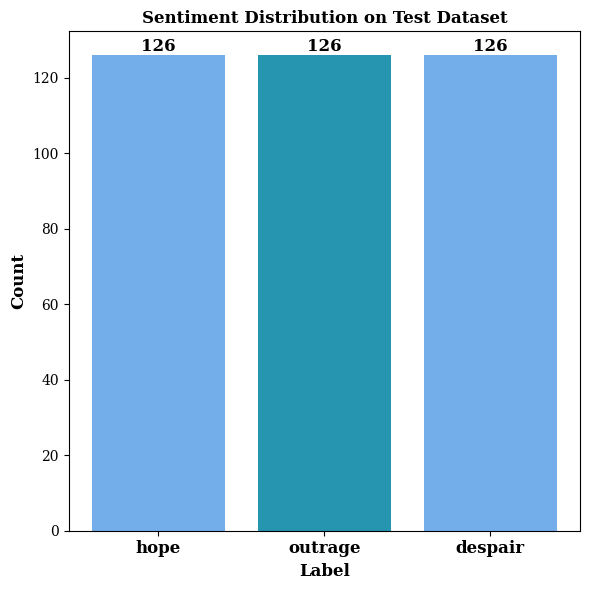

In [71]:
label_counts = test_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Test Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('D:\\Political_test.pdf')  # Save as pdf format
plt.show()


# **Visualization of Label Distribution in Validation Dataset**


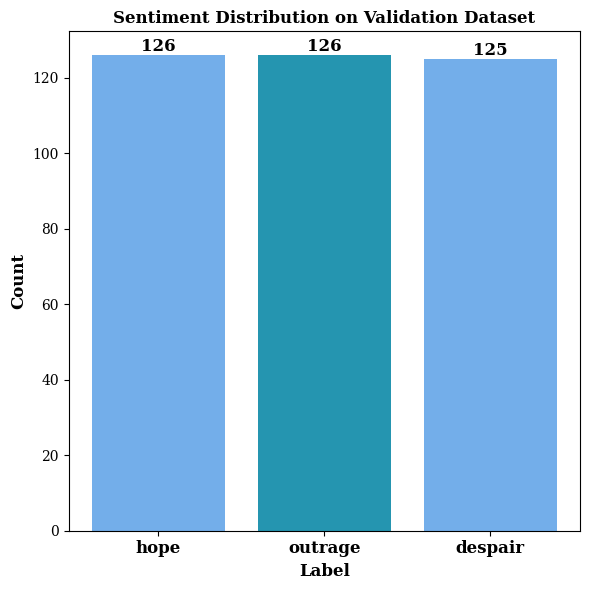

In [72]:
label_counts = val_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Validation Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('D:\\Political_validation.pdf')  # Save as pdf format
plt.show()


In [73]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")
print(f"Length of validation dataset: {len(val_data)}")

Length of train dataset: 1759
Length of test dataset: 378
Length of validation dataset: 377


# **Custom Dataset Class**

In [74]:
class BanglaPoliticalSentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Define a mapping for sentiment labels
        self.sentiment_map = {"outrage": 0, "hope": 1,"despair":2}  # You can add more sentiments if needed

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['Headline']
        label = self.data.iloc[idx]['Sentiment']

        # Convert sentiment label to integer using the mapping
        label = self.sentiment_map[label]

        inputs = self.tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long) #torch.nn.CrossEntropyLoss expects the target labels to be torch.LongTensor.
        }


In [76]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-9f8bont2
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-9f8bont2
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


In [77]:
!pip install transformers[sentencepiece]

In [78]:
!pip install torch

In [79]:
!pip install accelerate -U

# **BanglaBERT model and its tokenizer**

In [93]:
# Model loading
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
num_classes = 3  #number of classes in our dataset

model_name = "csebuetnlp/banglabert"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

# **Apply normalization to the datasets**

In [81]:
# Apply normalization to the datasets
train_data['Headline'] = train_data['Headline'].apply(normalize)
test_data['Headline'] = test_data['Headline'].apply(normalize)
val_data['Headline'] = val_data['Headline'].apply(normalize)

# **Custom dataset and dataloader**

In [82]:
# Define custom datasets
train_dataset = BanglaPoliticalSentimentDataset(train_data, tokenizer)
val_dataset = BanglaPoliticalSentimentDataset(val_data, tokenizer)
test_dataset = BanglaPoliticalSentimentDataset(test_data, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

# **Train Dataset Encoding Printing**

In [95]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


#     # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    2,  3517,  2509,  2423,   792, 17567,   810,  5309,  2593,  4916,
         5818,  4233,  1629,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# **Test Dataset Encoding Printing**

In [84]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
#     print("Input IDs:", input_ids)
#     print("Attention Mask:", attention_mask)
#     print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


# **Validation Dataset Encoding Printing**

In [85]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
#     print("Input IDs:", input_ids)
#     print("Attention Mask:", attention_mask)
#     print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


# **Train Dataset Decoding Printing**

In [86]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    #print("Decoded Input Text:", decoded_input_text)
    #print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    #print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


# **Test Dataset Decoding Printing**

In [87]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    #print("Decoded Input Text:", decoded_input_text)
    #print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    #print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


# **Validation Dataset Decoding Printing**

In [88]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    #print("Decoded Input Text:", decoded_input_text)
    #print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    #print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


In [90]:
torch.cuda.empty_cache()

# **Optimizer and Loss Function**

In [96]:
import torch.optim as optim
learning_rate = 2e-5
# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# **Training the model**

In [97]:
# Training loop
num_epochs = 20
gradient_accumulation_steps = 16  # Accumulate gradients over 4 steps

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average training loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    # Wrap val_loader with tqdm for progress bar
    for batch in tqdm(val_loader, desc=f'Validation', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        _, predicted = torch.max(logits, 1)

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}')

    # Calculate and print epoch training time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")

Epoch 1/20 - Average training loss: 1.0795


Epoch 1/20 - Validation Accuracy: 0.5570
Epoch 1 completed in 2m 56s


Epoch 2/20 - Average training loss: 0.9254


Epoch 2/20 - Validation Accuracy: 0.7056
Epoch 2 completed in 2m 58s


Epoch 3/20 - Average training loss: 0.6252


Epoch 3/20 - Validation Accuracy: 0.7401
Epoch 3 completed in 2m 58s


Epoch 4/20 - Average training loss: 0.3903


Epoch 4/20 - Validation Accuracy: 0.7772
Epoch 4 completed in 2m 58s


Epoch 5/20 - Average training loss: 0.2297


Epoch 5/20 - Validation Accuracy: 0.8090
Epoch 5 completed in 2m 58s


Epoch 6/20 - Average training loss: 0.1412


Epoch 6/20 - Validation Accuracy: 0.8196
Epoch 6 completed in 2m 58s


Epoch 7/20 - Average training loss: 0.0818


Epoch 7/20 - Validation Accuracy: 0.8143
Epoch 7 completed in 2m 58s


Epoch 8/20 - Average training loss: 0.0546


Epoch 8/20 - Validation Accuracy: 0.8223
Epoch 8 completed in 2m 58s


Epoch 9/20 - Average training loss: 0.0365


Epoch 9/20 - Validation Accuracy: 0.8223
Epoch 9 completed in 2m 58s


Epoch 10/20 - Average training loss: 0.0329


Epoch 10/20 - Validation Accuracy: 0.8355
Epoch 10 completed in 2m 58s


Epoch 11/20 - Average training loss: 0.0311


Epoch 11/20 - Validation Accuracy: 0.8249
Epoch 11 completed in 2m 58s


Epoch 12/20 - Average training loss: 0.0325


Epoch 12/20 - Validation Accuracy: 0.8249
Epoch 12 completed in 2m 58s


Epoch 13/20 - Average training loss: 0.0308


Epoch 13/20 - Validation Accuracy: 0.8196
Epoch 13 completed in 2m 58s


Epoch 14/20 - Average training loss: 0.0222


Epoch 14/20 - Validation Accuracy: 0.8276
Epoch 14 completed in 2m 58s


Epoch 15/20 - Average training loss: 0.0209


Epoch 15/20 - Validation Accuracy: 0.8196
Epoch 15 completed in 2m 57s


Epoch 16/20 - Average training loss: 0.0146


Epoch 16/20 - Validation Accuracy: 0.8382
Epoch 16 completed in 2m 57s


Epoch 17/20 - Average training loss: 0.0187


Epoch 17/20 - Validation Accuracy: 0.8223
Epoch 17 completed in 2m 57s


Epoch 18/20 - Average training loss: 0.0185


Epoch 18/20 - Validation Accuracy: 0.8143
Epoch 18 completed in 2m 57s


Epoch 19/20 - Average training loss: 0.0135


Epoch 19/20 - Validation Accuracy: 0.8090
Epoch 19 completed in 2m 57s


Epoch 20/20 - Average training loss: 0.0166


Epoch 20/20 - Validation Accuracy: 0.8143
Epoch 20 completed in 2m 58s


# **Testing the model**

In [98]:
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming our model directly outputs logits
        probabilities = torch.softmax(outputs.logits, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(outputs.logits, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')

Testing: 100%|██████████| 63/63 [00:13<00:00,  4.79it/s]


In [39]:
print(test_preds)
print(test_labels)

[0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 0, 1, 1, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1]
[0, 2, 1, 1, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1,

# **Printing the evaluation metric results**

In [99]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')

Test Accuracy: 0.8571428571428571
Test Precision: 0.8608957377614094
Test Recall: 0.8571428571428571
Test F1 Score: 0.8575856579960547


# **Confusion Matrix of Political_Sentiment_Analysis**

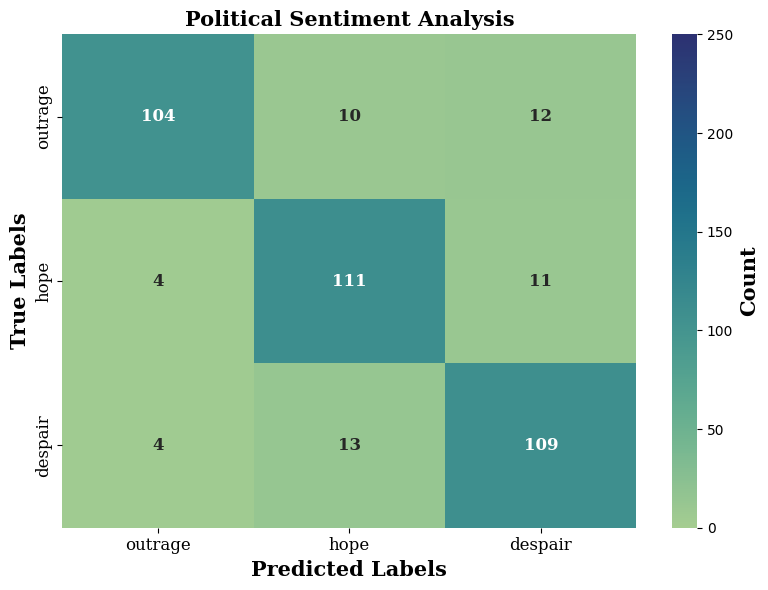

In [100]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
# Define the custom palette
custom_palette = sns.color_palette("crest", as_cmap=True)# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 15}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin = 0,vmax = 250,
                      xticklabels=['outrage', 'hope','despair'], yticklabels=['outrage', 'hope','despair'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Political Sentiment Analysis', fontdict=font)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('Bangla_Bert_Political_cm.pdf')  # Save as pdf format
plt.show()


# **Store predicted results to a csv file**

In [ ]:
# Combine the lists into a DataFrame
data = {'Content': test_data['short_description'],
        'True_Labels': test_data['sentiment'],
        'Predicted_Labels': test_preds}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('banglabert_predicted_results.csv', index=False)

# **save model, tokenizer, and classifier**

In [ ]:
# Save the model
model.save_pretrained('Bangla_political_Text_BanglaBERT_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('Bangla_political_Text_BanglaBERT_Tokenizer.json')



# **load model, tokenizer, and classifier**

In [ ]:
# load the model
model.from_pretrained('Bangla_political_Text_BanglaBERT_Model.pt')

# load the tokenizer
tokenizer.from_pretrained('Bangla_political_Text_BanglaBERT_Tokenizer.json')
